In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Processing
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 

# Evaluation
from sklearn.metrics import (confusion_matrix, precision_score, accuracy_score, precision_recall_curve, auc,
                             roc_curve, roc_auc_score, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, average_precision_score)

# MLI
from sklearn.model_selection import KFold
from lofo import LOFOImportance, plot_importance, Dataset
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots

pd.options.display.max_columns = 999

%matplotlib inline

## 1. Read train & test data

In [76]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train.sample(5)

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Total_Bill_Amount,Total_payment_Amount,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,Sex_Marriage_10,Sex_Marriage_11,Sex_Marriage_12,Sex_Marriage_13,Sex_Marriage_20,Sex_Marriage_21,Sex_Marriage_22,Sex_Marriage_23,Sex_Education_10,Sex_Education_11,Sex_Education_12,Sex_Education_13,Sex_Education_14,Sex_Education_20,Sex_Education_21,Sex_Education_22,Sex_Education_23,Sex_Education_24,Sex_Education_Marriage_101,Sex_Education_Marriage_102,Sex_Education_Marriage_110,Sex_Education_Marriage_111,Sex_Education_Marriage_112,Sex_Education_Marriage_113,Sex_Education_Marriage_120,Sex_Education_Marriage_121,Sex_Education_Marriage_122,Sex_Education_Marriage_123,Sex_Education_Marriage_130,Sex_Education_Marriage_131,Sex_Education_Marriage_132,Sex_Education_Marriage_133,Sex_Education_Marriage_141,Sex_Education_Marriage_142,Sex_Education_Marriage_143,Sex_Education_Marriage_201,Sex_Education_Marriage_202,Sex_Education_Marriage_210,Sex_Education_Marriage_211,Sex_Education_Marriage_212,Sex_Education_Marriage_213,Sex_Education_Marriage_220,Sex_Education_Marriage_221,Sex_Education_Marriage_222,Sex_Education_Marriage_223,Sex_Education_Marriage_230,Sex_Education_Marriage_231,Sex_Education_Marriage_232,Sex_Education_Marriage_233,Sex_Education_Marriage_241,Sex_Education_Marriage_242,Sex_Education_Marriage_243,Age_category_29 - 34,Age_category_35 - 41,Age_category_<=28,Age_category_>41,default.payment.next.month
25718,94056.792421,87666.818293,86782.430744,86580.728704,88623.728971,76209.079575,78215.271949,3101.782962,3702.839621,4118.864152,2861.699506,3581.356351,5839.754695,504078.058237,23206.297286,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
18972,250000.000000,964.000000,69000.000000,63462.000000,45710.000000,43537.000000,38367.000000,69032.000000,2138.000000,1566.000000,1582.000000,1318.000000,1630.000000,261040.000000,77266.000000,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
14371,320000.000000,1877.000000,4094.000000,4664.000000,3878.000000,22483.000000,4097.000000,4114.000000,4687.000000,3985.000000,22595.000000,4117.000000,5838.000000,41093.000000,45336.000000,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13097,60000.000000,39068.000000,40107.000000,41137.000000,43644.000000,44498.000000,45417.000000,1970.000000,2000.000000,3500.000000,1700.000000,1800.000000,0.000000,253871.000000,10970.000000,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
35211,182505.591443,409.502077,409.502077,2

In [77]:
unique, counts = np.unique(train['default.payment.next.month'], return_counts=True)
cnt_dict = dict(zip(unique, counts/train.shape[0]))
pd.DataFrame(list(cnt_dict.items()), columns=['Class', 'Percentage'])

,Class,Percentage
0,0,0.5
1,1,0.5


## 2. Modelling

In [78]:
X_train = train.drop('default.payment.next.month',axis=1)
y_train = train['default.payment.next.month']

X_test = test.drop('default.payment.next.month',axis=1)
y_test = test['default.payment.next.month']

### Best Model - LightGBM

In [79]:
lgbm = LGBMClassifier(learning_rate= 0.1, n_estimators= 100, num_leaves= 25)
lgbm.fit(X_test, y_test)
y_test_pred = lgbm.predict(X_test)

## 3. MLI

### Surrogate Model

#### 1. Logistic Regression

In [49]:
lr_clf = LogisticRegression(max_iter=200)

# Create param grid.

param_grid = {
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','lbfgs']
}

# Create grid search object

clf = GridSearchCV(lr_clf, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data

clf.fit(X_test, y_test_pred)

print(f"\nBest model for Light GBM: \n{clf.best_params_}\n")
print(f"Best cross-validation score for Light GBM: {clf.best_score_}\n")

Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best model for Light GBM: 
{'C': 0.0006951927961775605, 'solver': 'lbfgs'}

Best cross-validation score for Light GBM: 0.8618333333333332



In [6]:
lr = LogisticRegression(solver='lbfgs', C=0.00069 ,max_iter=200)
lr.fit(X_test, y_test_pred)
print('Accuracy Score of Logistic Regression is',lr.score(X_test, y_test))

Accuracy Score of Logistic Regression is 0.78


In [7]:
coef = pd.DataFrame(np.transpose(lr.coef_),columns=['coef'])
feature = pd.DataFrame(X_train.columns,columns=['feature'])
feature_coef = pd.concat([feature,coef],axis=1)

In [31]:
feature_coef = feature_coef[feature_coef['coef'].abs()>0.00001].reset_index() # choose a threshold

In [33]:
feature_coef

,index,feature,coef
0,1,BILL_AMT1,-0.000017
1,7,PAY_AMT1,-0.000066
2,10,PAY_AMT4,-0.000017
3,11,PAY_AMT5,0.000022
4,12,PAY_AMT6,0.000025
5,14,Total_payment_Amount,-0.000028


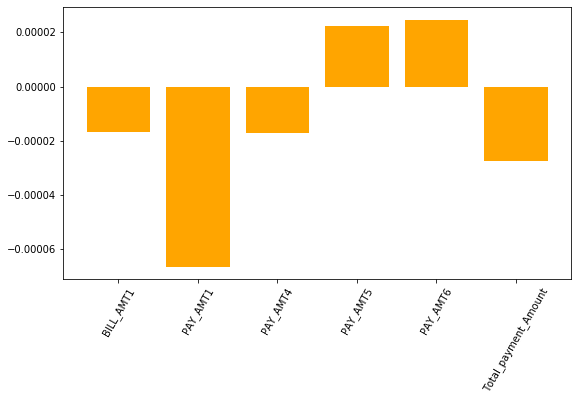

In [66]:
fig = plt.figure(figsize=(20,5))
data = feature_coef['coef']
labels = feature_coef['feature']

ax=plt.subplot(122)
plt.bar(np.arange(data.size), data,color='orange')
ax.set_xticks(np.arange(data.size))
ax.set_xticklabels(labels)
plt.xticks(rotation=60)
plt.show()

In [17]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p


In [59]:
model = LogisticRegression(solver='lbfgs', C=0.00069 ,max_iter=200)
model.fit(X_test[feature_coef['feature'].to_list()], y_test)
p_value = pd.DataFrame(logit_pvalue(model, X_test[feature_coef['feature'].to_list()]),columns=['pvalue'])

In [64]:
p_value = pd.concat([feature_coef,p_value.drop([0]).reset_index(drop=True)],axis=1)

In [65]:
p_value

,index,feature,coef,pvalue
0,1,BILL_AMT1,-0.000017,3.462762e-01
1,7,PAY_AMT1,-0.000066,1.644519e-02
2,10,PAY_AMT4,-0.000017,2.479942e-01
3,11,PAY_AMT5,0.000022,4.416368e-05
4,12,PAY_AMT6,0.000025,1.627117e-06
5,14,Total_payment_Amount,-0.000028,2.220446e-16


#### 2. Decision Tree

In [72]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_test, y_test_pred)
print('Accuracy Score of Classification Tree is',dt.score(X_test, y_test))

Accuracy Score of Classification Tree is 0.8113333333333334


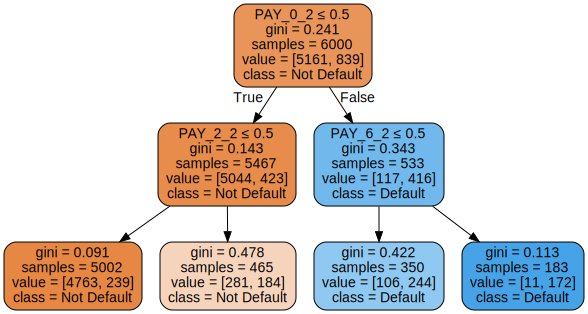

In [73]:
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=X_test.columns, class_names=['Not Default','Default'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data) 
graph

### Leave One Covariate Out (LOCO)

In [90]:
# define the validation scheme
cv = KFold(n_splits=4, shuffle=False)
# define the binary target and the features
target="default.payment.next.month"
dataset = Dataset(df=test, target="default.payment.next.month", features=[col for col in test.columns if col != target])
# define the validation scheme and scorer. The default model is LightGBM
lofo = LOFOImportance(dataset, scoring="roc_auc", cv=cv)
# get the mean and standard deviation of the importances in pandas format
importance_df = lofo.get_importance()
importance_df.head()

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
0,LIMIT_BAL,0.004900,0.003986,0.005794,0.010867,0.000126,0.002812
13,Total_Bill_Amount,0.003173,0.001862,0.005147,0.004732,0.000604,0.002207
39,PAY_2_0,0.001907,0.003508,-0.001121,0.007203,-0.001398,0.002944
50,PAY_3_0,0.001906,0.004172,0.000983,0.008828,-0.002288,0.000099
129,Sex_Education_Marriage_212,0.001648,0.001323,-0.000411,0.003162,0.001516,0.002324


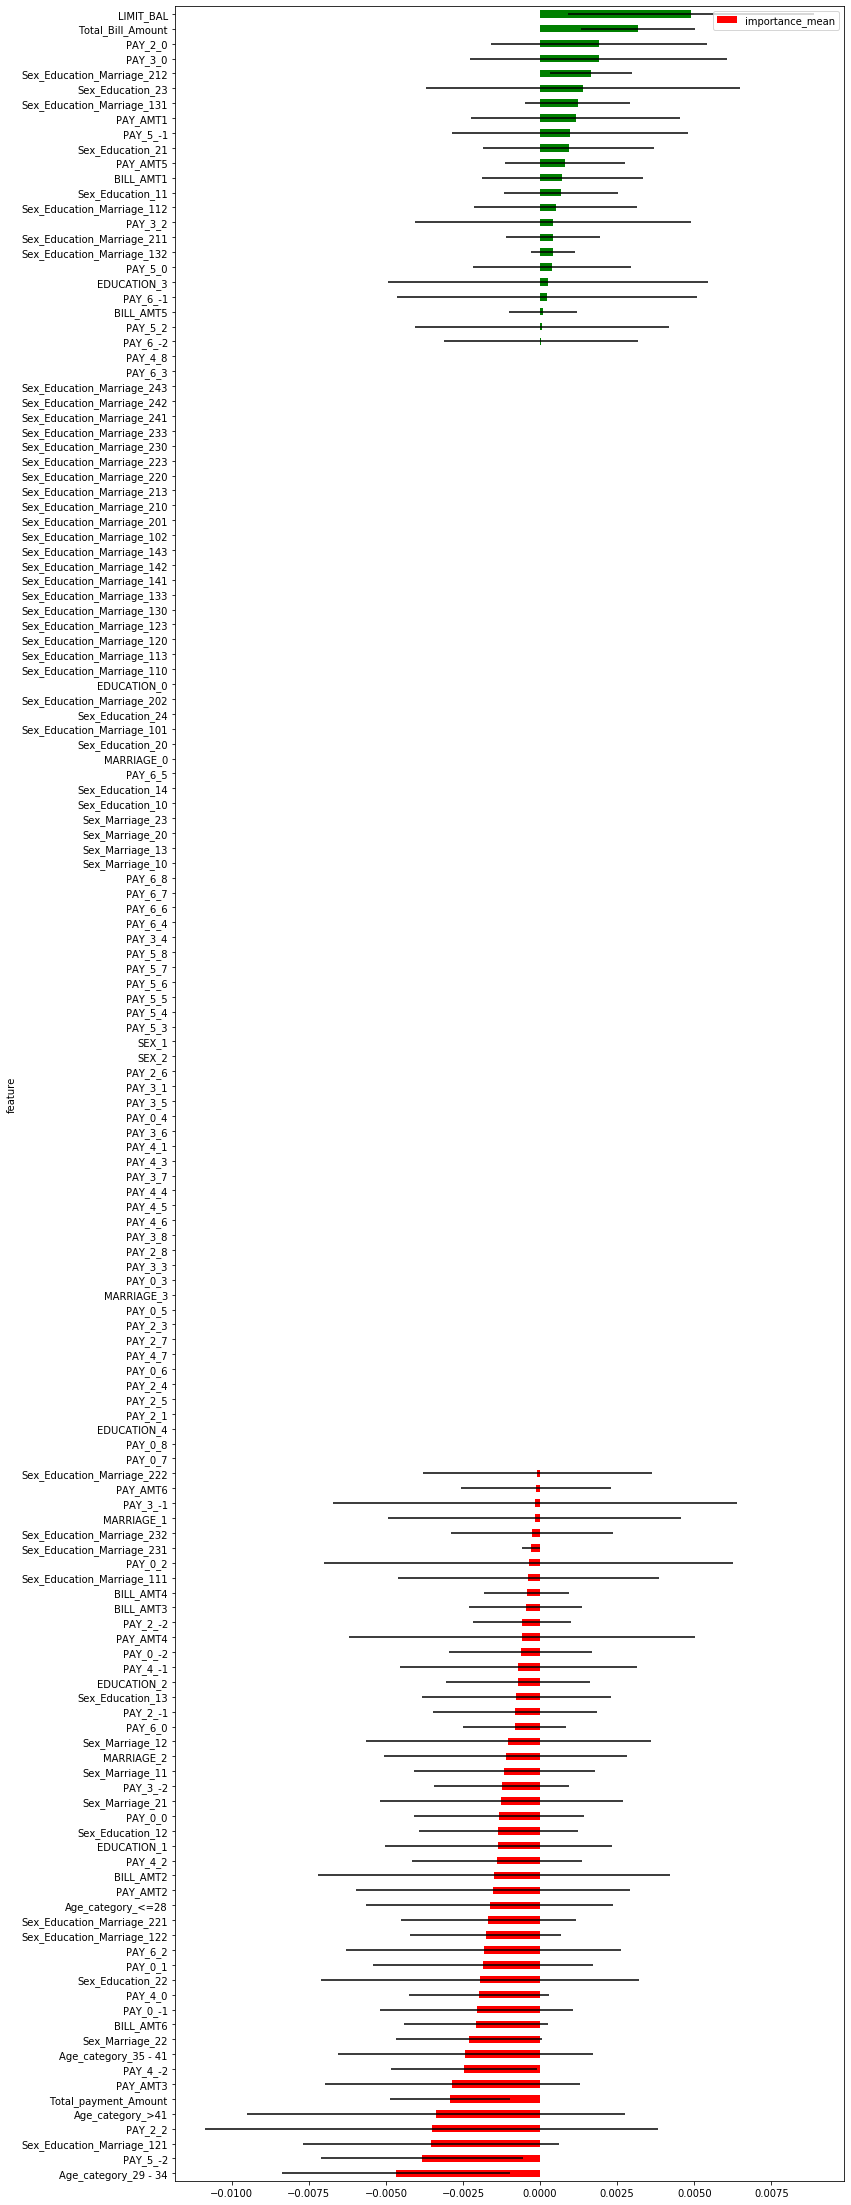

In [92]:
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 40))

### Permutation Feature Importance

In [93]:
perm = PermutationImportance(lgbm).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0435 ± 0.0020,PAY_0_2
0.0202 ± 0.0035,Total_payment_Amount
0.0186 ± 0.0024,PAY_AMT6
0.0177 ± 0.0024,BILL_AMT1
0.0170 ± 0.0016,PAY_AMT3
0.0164 ± 0.0025,LIMIT_BAL
0.0145 ± 0.0023,PAY_AMT1
0.0137 ± 0.0026,PAY_AMT4
0.0133 ± 0.0036,BILL_AMT4
0.0132 ± 0.0007,BILL_AMT2


### Partial Dependence Plot

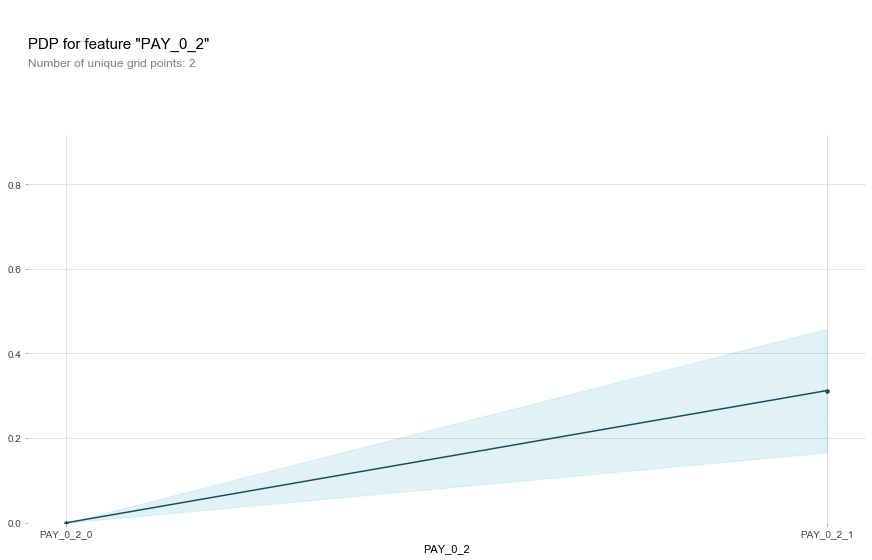

In [81]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=lgbm, dataset=X_test, model_features=X_test.columns.tolist(), feature='PAY_0_2')

# plot it
pdp.pdp_plot(pdp_goals, 'PAY_0_2')
plt.show()

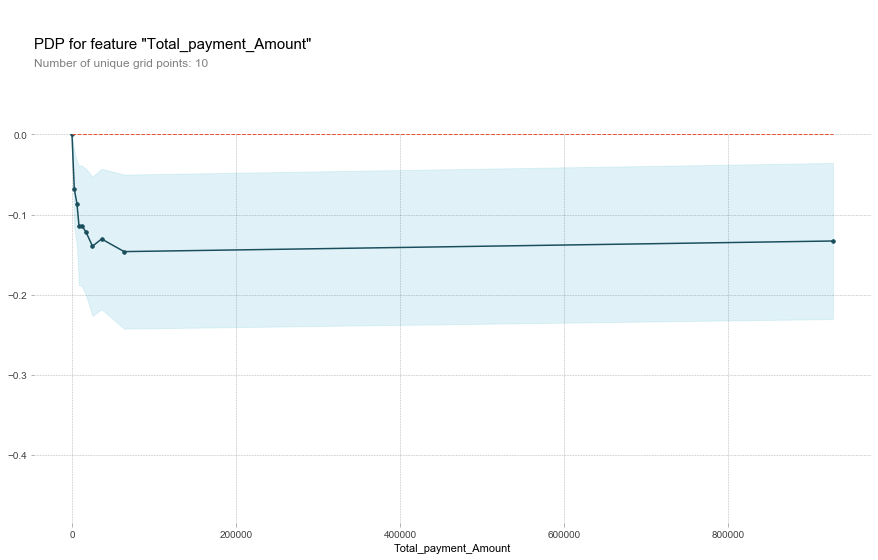

In [97]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=lgbm, dataset=X_test, model_features=X_test.columns.tolist(), feature='Total_payment_Amount')

# plot it
pdp.pdp_plot(pdp_goals, 'Total_payment_Amount')
plt.show()

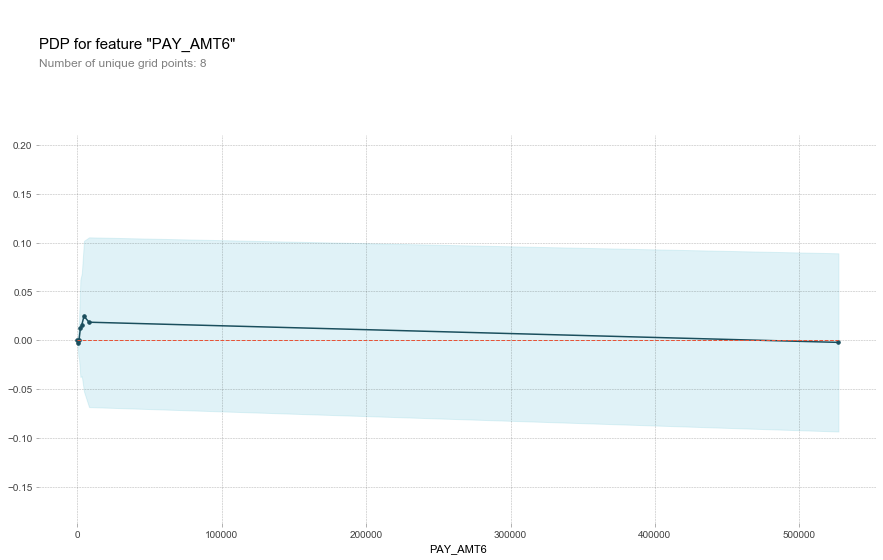

In [98]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=lgbm, dataset=X_test, model_features=X_test.columns.tolist(), feature='PAY_AMT6')

# plot it
pdp.pdp_plot(pdp_goals, 'PAY_AMT6')
plt.show()

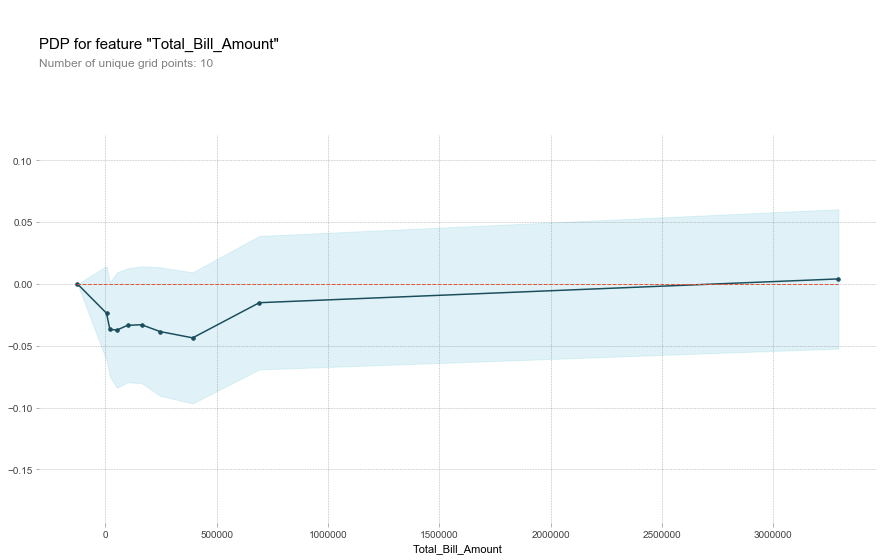

In [82]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=lgbm, dataset=X_test, model_features=X_test.columns.tolist(), feature='Total_Bill_Amount')

# plot it
pdp.pdp_plot(pdp_goals, 'Total_Bill_Amount')
plt.show()

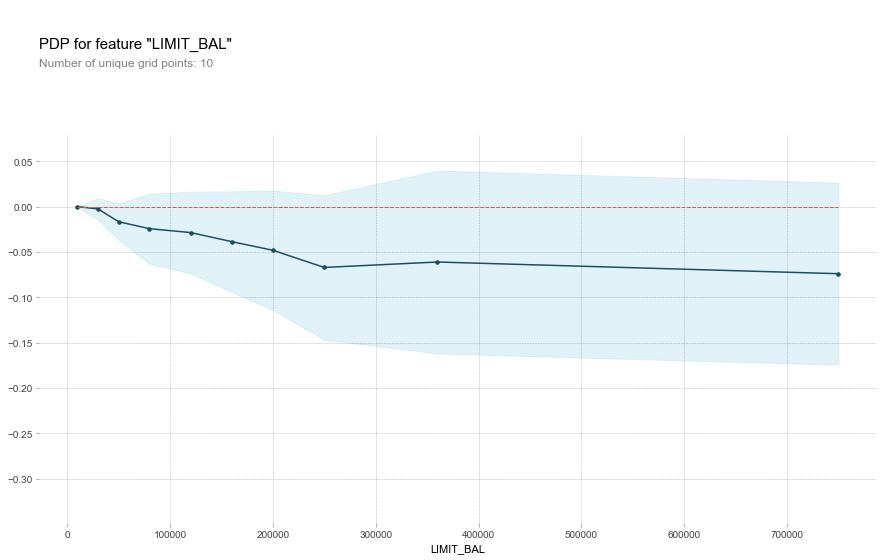

In [83]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=lgbm, dataset=X_test, model_features=X_test.columns.tolist(), feature='LIMIT_BAL')

# plot it
pdp.pdp_plot(pdp_goals, 'LIMIT_BAL')
plt.show()